## Setup

In [1]:
import numpy as np
import pandas as pd

In [2]:
import os
is_kaggle = 'KAGGLE_KERNEL_RUN_TYPE' in os.environ
is_colab = 'COLAB_JUPYTER_TOKEN' in os.environ
is_interactive = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', 'Unknown') == 'Interactive' or is_colab

is_interactive

False

In [3]:
libraries = [
    'functools',
    'gc',
    'gzip',
    'hashlib',
    'matplotlib',
    'numpy',
    'os',
    'pandas',
    'scikit-learn',
    'torch',
    'tqdm',
    'transformers'
]

if is_colab:
    import subprocess
    for lib in libraries:
        subprocess.run(["pip", "install", lib])
    from google.colab import drive
    drive.mount('/content/drive')
    

In [4]:
import random
import numpy as np
import torch

def set_seed(seed_value):
    """Set seed for reproducibility."""
    random.seed(seed_value)            # Set seed for python's built-in random
    np.random.seed(seed_value)         # Set seed for numpy
    torch.manual_seed(seed_value)      # Set seed for pytorch

    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seed(42)  # Use any number as seed


## Load Data

In [5]:
def load_data_in_kaggle():
    df_train_prompts = pd.read_csv('/kaggle/input/commonlit-evaluate-student-summaries/prompts_train.csv')
    df_train_summaries = pd.read_csv('/kaggle/input/commonlit-evaluate-student-summaries/summaries_train.csv')
    df_test_prompts = pd.read_csv('/kaggle/input/commonlit-evaluate-student-summaries/prompts_test.csv')
    df_test_summaries = pd.read_csv('/kaggle/input/commonlit-evaluate-student-summaries/summaries_test.csv')
    return df_train_prompts, df_train_summaries,df_test_prompts, df_test_summaries

def load_data_in_colab():
    base_path = "/content/drive/MyDrive/kaggle/commonlit-evaluate-student-summaries/"
    df_train_prompts = pd.read_csv(base_path + 'prompts_train.csv')
    df_train_summaries = pd.read_csv(base_path + 'summaries_train.csv')
    df_test_prompts = pd.read_csv(base_path + 'prompts_test.csv')
    df_test_summaries = pd.read_csv(base_path + 'summaries_test.csv')
    return df_train_prompts, df_train_summaries, df_test_prompts, df_test_summaries


def load_data():
    if is_kaggle:
        return load_data_in_kaggle()
    if is_colab:
        return load_data_in_colab()


df_train_prompts, df_train_summaries,df_test_prompts, df_test_summaries = load_data()

## Merge set

In [6]:
df_train = df_train_summaries.merge(df_train_prompts, on='prompt_id')
df_test = df_test_summaries.merge(df_test_prompts, on='prompt_id')

df_test["wording"] = 0.0
df_test["content"] = 0.0

print(f"df_train.shape: {df_train.shape}")
print(f"df_test.shape: {df_test.shape}")

df_train.head()

df_train.shape: (7165, 8)
df_test.shape: (4, 8)


,student_id,prompt_id,text,content,wording,prompt_question,prompt_title,prompt_text
0,000e8c3c7ddb,814d6b,The third wave was an experimentto see how peo...,0.205683,0.380538,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...
1,0070c9e7af47,814d6b,The Third Wave developed rapidly because the ...,3.272894,3.219757,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...
2,0095993991fe,814d6b,The third wave only started as an experiment w...,0.205683,0.380538,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...
3,00c20c6ddd23,814d6b,The experimen was orginally about how even whe...,0.567975,0.969062,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...
4,00d40ad10dc9,814d6b,The third wave developed so quickly due to the...,-0.910596,-0.081769,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...


## Features

In [7]:
# Define a separator token for BERT
separator_token = ' [SEP] '

# Create the "full_text" feature by joining "prompt_text" and "text"
df_train['full_text'] = df_train['text'] + separator_token + df_train['prompt_question']
df_test['full_text'] = df_test['text'] + separator_token + df_test['prompt_question']

df_train['word_count'] = df_train['text'].apply(lambda x: len(str(x).split()))
df_test['word_count'] = df_test['text'].apply(lambda x: len(str(x).split()))

import gzip

def calculate_compressed_size(text):
    text_bytes = text.encode('utf-8')
    compressed_bytes = gzip.compress(text_bytes)
    return len(compressed_bytes)

df_train['lexical_similarity'] = df_train.apply(
    lambda row: 1 - calculate_compressed_size(row['text'] + row['prompt_text']) / (calculate_compressed_size(row['text']) + calculate_compressed_size(row['prompt_text'])),
    axis=1
)
df_test['lexical_similarity'] = df_train.apply(
    lambda row: 1 - calculate_compressed_size(row['text'] + row['prompt_text']) / (calculate_compressed_size(row['text']) + calculate_compressed_size(row['prompt_text'])),
    axis=1
)

In [8]:
import torch

if torch.cuda.is_available():    
    n_gpu = torch.cuda.device_count()
    device_ids = list(range(n_gpu))
    device = torch.device(f'cuda:{device_ids[0]}')  # Choose the first device
    print('There are %d GPU(s) available.' % n_gpu)
    print('We will use the GPUs:', device_ids)
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")
    device_ids = None

There are 2 GPU(s) available.
We will use the GPUs: [0, 1]


In [9]:
from transformers import AutoModel, AutoTokenizer, AutoConfig, AutoModelForSequenceClassification
import torch

def load_pretrained_on_kaggle():
    MODEL_PATH = '/kaggle/input/debertav3base'

    # Load tokenizer and model
    tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)
    model = AutoModel.from_pretrained(MODEL_PATH)

    return model, tokenizer


def load_pretrained_on_colab():
    MODEL_PATH = '/content/drive/MyDrive/kaggle/debertav3base'

    # Load tokenizer and model
    tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)
    model = AutoModel.from_pretrained(MODEL_PATH)

    return model, tokenizer


def load_pretrained():
    if is_kaggle:
        return load_pretrained_on_kaggle()
    if is_colab:
        return load_pretrained_on_colab()

In [10]:
import pandas as pd
import torch
from sklearn.metrics.pairwise import cosine_similarity
import hashlib
from functools import lru_cache

semantic_model, tokenizer = load_pretrained()
semantic_model.to(device)

if device_ids:
    semantic_model = torch.nn.DataParallel(semantic_model, device_ids=device_ids) # Wrap the model with DataParallel

maxsize = None if is_interactive else 128    
@lru_cache(maxsize=maxsize)
def get_embedding(text):
    inputs = tokenizer(text, max_length=512, truncation=True, padding='max_length', return_tensors='pt')

    if device_ids:
        inputs = {name: tensor.to(device) for name, tensor in inputs.items()}  # move inputs to GPU
    with torch.no_grad():
        outputs = semantic_model(**inputs)
    
    embedding = outputs.last_hidden_state.mean(dim=1).cpu().numpy()
    return embedding

# Compute embeddings and similarity score
def get_similarity(row):
    prompt_embedding = get_embedding(row['prompt_text'])
    text_embedding = get_embedding(row['text'])
    similarity = cosine_similarity(prompt_embedding, text_embedding)
    return similarity[0][0]

# Add similarity score to DataFrame
df_train['semantic_similarity'] = df_train.apply(get_similarity, axis=1)
df_test['semantic_similarity'] = df_test.apply(get_similarity, axis=1)

print("Done!")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/opt/conda/lib/python3.10/site-packages/transformers/convert_slow_tokenizer.py:454: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/opt/conda/lib/p

Done!


In [11]:
import gc

del semantic_model
del tokenizer
gc.collect()

0

## Scale

In [12]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


# Features you want to scale
features_to_scale = ["word_count", "semantic_similarity", "lexical_similarity"]

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler only on the training data for the selected features
df_train[features_to_scale] = scaler.fit_transform(df_train[features_to_scale])

# Transform the test data using the same scaler for the selected features
df_test[features_to_scale] = scaler.transform(df_test[features_to_scale])


## Cross Validation

In [13]:
from sklearn.model_selection import KFold
import pandas as pd

def split_dataframe_by_prompt(df, n_splits=4):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    combined_train_dfs = []
    combined_val_dfs = []

    unique_prompts = df['prompt_id'].unique()

    for train_prompt_ids, val_prompt_ids in kf.split(unique_prompts):
        train_dataframes = [df[df['prompt_id'] == unique_prompts[id]] for id in train_prompt_ids]
        val_dataframes = [df[df['prompt_id'] == unique_prompts[id]] for id in val_prompt_ids]

        combined_train_dfs.append(pd.concat(train_dataframes))
        combined_val_dfs.append(pd.concat(val_dataframes))

    return combined_train_dfs, combined_val_dfs

# Usage:
train_4_fold_dfs, val_4_fold_dfs = split_dataframe_by_prompt(df_train)

# To get the dataframes for a specific fold:
fold_number = 1  # This can be 0, 1, 2, or 3
df_4_fold_train = train_4_fold_dfs[fold_number]
df_4_fold_val = val_4_fold_dfs[fold_number]
df_val = df_4_fold_val

## Loss

In [14]:
import numpy as np

def compute_mcrmse(df):
    def rmse(actual, predictions):
        return np.sqrt(np.mean((actual - predictions)**2))

    rmse_content = rmse(df['content'], df['predicted_content'])
    rmse_wording = rmse(df['wording'], df['predicted_wording'])

    mcrmse = np.mean([rmse_content, rmse_wording])
    
    return mcrmse, rmse_content, rmse_wording

## Training

In [15]:
import torch
from torch import nn
from torch.optim import AdamW
from transformers import DistilBertTokenizer, DistilBertModel
from torch.utils.data import Dataset, DataLoader

class TextDataset(Dataset):
    def __init__(self, df, tokenizer, max_length):
        self.df = df
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        row = self.df.iloc[index]
        text = row['full_text']
        inputs = self.tokenizer.encode_plus(
            text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        inputs['input_ids'] = inputs['input_ids'].squeeze()
        inputs['attention_mask'] = inputs['attention_mask'].squeeze()
        inputs['word_count'] = torch.tensor(row['word_count'], dtype=torch.float)  # Add word_count to inputs
        inputs['lexical_similarity'] = torch.tensor(row['lexical_similarity'], dtype=torch.float)  # Add word_count to inputs
        inputs['semantic_similarity'] = torch.tensor(row['semantic_similarity'], dtype=torch.float)  # Add semantic_similarity to inputs
        return inputs, torch.tensor([row['content'], row['wording']], dtype=torch.float)

class RegressionModel(nn.Module):
    def __init__(self, base_model):
        super().__init__()
        self.base_model = base_model
        # Safely retrieve the hidden size
        embedding_size = getattr(base_model.config, 'hidden_size', None)
        if embedding_size is None:
            raise ValueError(f"'hidden_size' not found in config of model {type(base_model)}")
        self.regressor = nn.Linear(embedding_size + 3, 2)  # + 3 for word_count, lexical_similarity, semantic_similarity

    def forward(self, **inputs):
        word_count = inputs.pop('word_count').unsqueeze(-1)  # Add an extra dimension
        lexical_similarity = inputs.pop('lexical_similarity').unsqueeze(-1)  # Add lexical_similarity
        semantic_similarity = inputs.pop('semantic_similarity').unsqueeze(-1)  # Add lexical_similarity
        outputs = self.base_model(**inputs)
        sentence_embedding = outputs.last_hidden_state.mean(dim=1)
        combined_embedding = torch.cat((sentence_embedding, lexical_similarity, semantic_similarity, word_count), dim=1)
        return self.regressor(combined_embedding)


class MCRMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss(reduction='none')  # We will handle the mean computation manually

    def forward(self, pred, target):
        squared_errors = self.mse(pred, target)
        rmse_per_column = torch.sqrt(torch.mean(squared_errors, dim=0))
        mcrmse = torch.mean(rmse_per_column)
        return mcrmse

In [16]:
def predict_with_transformer(model, tokenizer, dataframe, batch_size=4):
    """Use the transformer model to make predictions in batches."""
    
    # Helper function to batch data
    def get_batched_data(data, start_idx, end_idx, dtype=torch.float, device=device):
        return torch.tensor(data[start_idx:end_idx], dtype=dtype).to(device)
    
    # Set the model to evaluation mode
    model.eval()
    
    texts = dataframe['full_text'].tolist()
    columns_to_tensor = ['lexical_similarity', 'semantic_similarity', 'word_count']
    total_samples = len(texts)

    predicted_content = []
    predicted_wording = []

    for i in range(0, total_samples, batch_size):
        inputs = tokenizer(texts[i:i+batch_size], truncation=True, padding="max_length", return_tensors="pt", max_length=512)
        
        # Convert columns to tensors and add to inputs
        for col in columns_to_tensor:
            inputs[col] = get_batched_data(dataframe[col].values, i, i+batch_size)
        
        # Send all inputs to device (e.g., GPU)
        inputs = {k: v.to(device) for k, v in inputs.items()} 

        with torch.no_grad():
            outputs = model(**inputs)
        
        # Append results to lists
        predicted_content.extend(outputs[:, 0].cpu().numpy())
        predicted_wording.extend(outputs[:, 1].cpu().numpy())

    return predicted_content, predicted_wording


In [17]:
import torch.optim as optim
from tqdm import tqdm
from torch.nn.utils import clip_grad_norm_

DROPOUT = 0.0
MAX_GRAD_NORM = 1.0
WEIGHT_DECAY = 0.01

def train_model(df_train, num_epochs=3):

    # Load tokenizer and model
    base_model, tokenizer = load_pretrained()
    # Set dropout probability
    base_model.config.hidden_dropout_prob = DROPOUT
    base_model.config.attention_probs_dropout_prob = DROPOUT

    # Create the regression model
    model = RegressionModel(base_model)
    if torch.cuda.device_count() > 1:
        print("Let's use", torch.cuda.device_count(), "GPUs!")
        model = nn.DataParallel(model, device_ids=device_ids)  # Use all available GPUs
    model.to(device)

    # Prepare the data
    dataset_train = TextDataset(df_train, tokenizer, max_length=512)
    dataloader_train = DataLoader(dataset_train, batch_size=16, shuffle=True)

    # Set up the optimizer and loss function
    optimizer = optim.AdamW(model.parameters(), lr=2e-5, weight_decay=WEIGHT_DECAY)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.9)  # Reduces the LR every 1000 steps by a factor of 0.9
    loss_func = MCRMSELoss()

    # Initialize a list to record average losses over time
    loss_history = []

    # Training loop
    running_loss = 0.0
    for epoch in range(num_epochs):
        model.train()
        
        # Wrap the dataloader with tqdm to get a progress bar
        progress_bar = tqdm(dataloader_train, desc=f"Epoch {epoch+1}/{num_epochs}")
        for i, batch in enumerate(progress_bar):
            optimizer.zero_grad()
            inputs, labels = batch
            inputs = {k: v.to(device) for k, v in inputs.items()}
            labels = labels.to(device)
            outputs = model(**inputs)
            loss = loss_func(outputs, labels)
            loss.backward()
            clip_grad_norm_(model.parameters(), MAX_GRAD_NORM)
            optimizer.step()
            
            # Update the running loss and display it in tqdm's description
            current_loss = loss.item()
            running_loss += current_loss
            loss_history.append(current_loss)
            if i % 10 == 9:  # Print every 10 batches
                avg_loss = running_loss / 10
                progress_bar.set_description(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")
                running_loss = 0.0
        scheduler.step()

    return model, loss_history

# Usage:
if is_interactive:
    model, train_loss = train_model(df_4_fold_train)
else:
    model, train_loss = train_model(df_train)


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/opt/conda/lib/python3.10/site-packages/transformers/convert_slow_tokenizer.py:454: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Some weights of the model checkpoint at /kaggle/input/debertav3base were not used when initializing DebertaV2Model: ['mask_predictions.LayerNorm.bias', 'mask_predictions.dense.weight', 'mask_predictions.LayerNorm.weight', 'mask_predictions.dense.bias', 'lm_predictio

Let's use 2 GPUs!


Epoch 3/3, Loss: 0.4488: 100%|██████████| 448/448 [10:11<00:00,  1.36s/it]


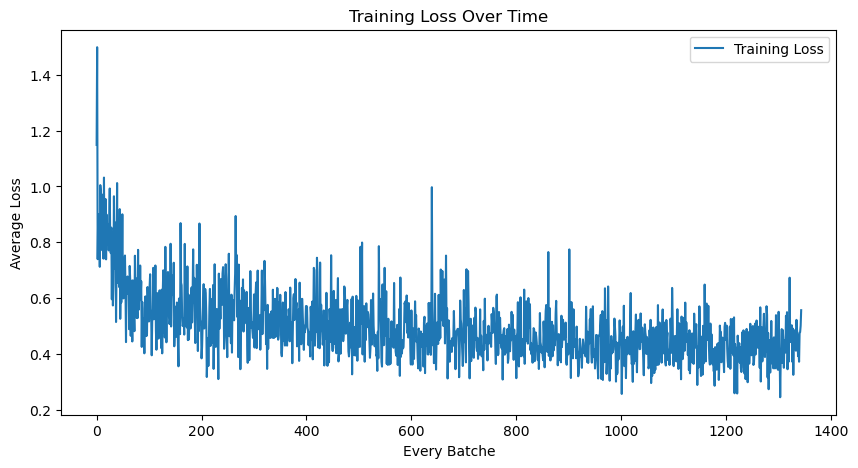

In [18]:
import matplotlib.pyplot as plt

# Plotting the loss history
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss')
plt.title('Training Loss Over Time')
plt.xlabel('Every Batche')
plt.ylabel('Average Loss')
plt.legend()
plt.show()

## Inference

In [19]:

_, tokenizer = load_pretrained()

# Now predict in batches:
df_val['predicted_content'], df_val['predicted_wording'] = predict_with_transformer(model, tokenizer, df_val)
df_test['content'], df_test['wording'] = predict_with_transformer(model, tokenizer, df_test)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Some weights of the model checkpoint at /kaggle/input/debertav3base were not used when initializing DebertaV2Model: ['mask_predictions.LayerNorm.bias', 'mask_predictions.dense.weight', 'mask_predictions.LayerNorm.weight', 'mask_predictions.dense.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.LayerNorm.weight']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT

## Evaluation

In [20]:
print("df_val")
print(compute_mcrmse(df_val))

df_val
(0.4213328749671244, 0.3339528541706419, 0.5087128957636069)


## Submit

In [21]:
print(f"df_test.shape: {df_test.shape}")

def is_valid_float(x):
    return isinstance(x, float) and x == x  # This checks that x is not NaN since NaN != NaN in Python.

# Replace non-float values in 'wording' and 'content' with zero
cols_to_check = ['wording', 'content']
df_test[cols_to_check] = df_test[cols_to_check].applymap(lambda x: x if is_valid_float(x) else 0.0)
 
df_test[['student_id', 'content', 'wording']].to_csv('submission.csv',index=False)
display(pd.read_csv('submission.csv'))

df_test.shape: (4, 12)


,student_id,content,wording
0,000000ffffff,-1.277360,-0.834852
1,222222cccccc,-1.281065,-0.813375
2,111111eeeeee,-1.280243,-0.817175
3,333333dddddd,-1.281941,-0.809116
